# Synthetic Data Generation

In [1]:
#Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from math import ceil
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display
import warnings
from datetime import datetime, timedelta

#Scikit-learn imports
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy.stats import beta

#Bayesian imports
import arviz as az
import pytensor.tensor as pt
import pymc as pm
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.21.1


## 1. Date Range and Channels

### Raw Signal

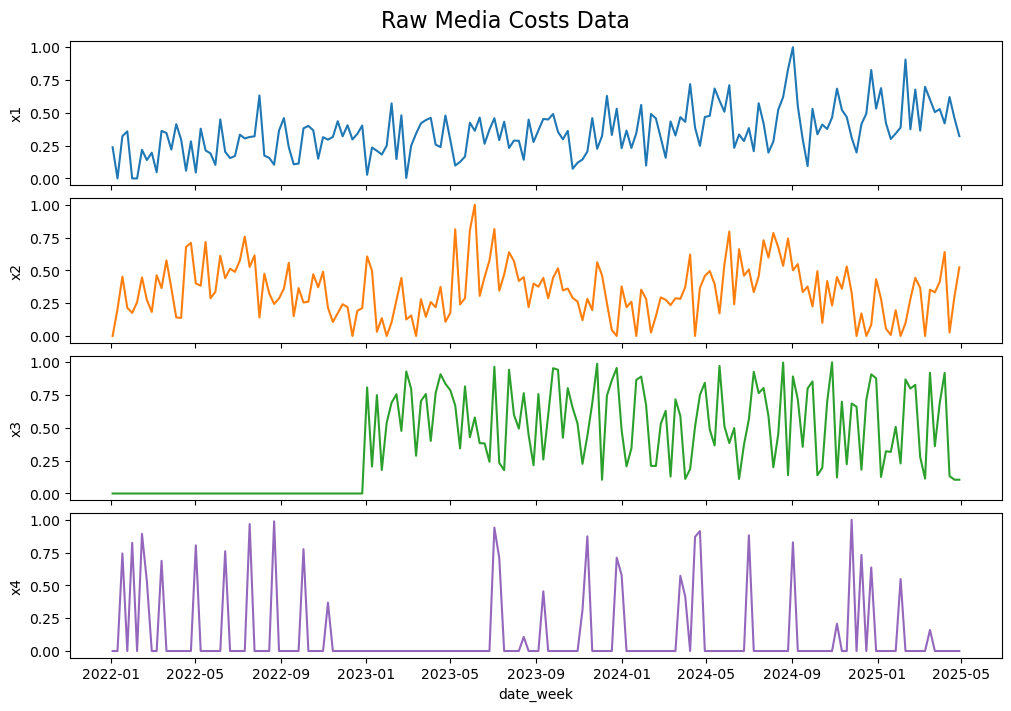

In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
rng = np.random.default_rng(42)

### 1. Date Range ###
# Define the start and end dates
start_date = "2022-01-03"
end_date = datetime.today().strftime("%Y-%m-%d")

# Generate a DataFrame with weekly dates
df = pd.DataFrame(
    data={"date_week": pd.date_range(start=start_date, end=end_date, freq="W-MON")}
)

# Number of weeks
n = df.shape[0]

### 2. Media Data ###
# x1: Increasing trend with noise
x1 = np.linspace(5000, 15000, n)
x1_noise = rng.normal(50, 5000, n)  # Additive noise
x1 = (x1 + x1_noise).clip(0).astype(int)  # Ensure non-negative values

# x2: Seasonality with noise (peaks in summer, drops around Christmas)
days_in_year = 365.25
seasonality = -np.cos(2 * np.pi * (df["date_week"].dt.dayofyear) / days_in_year) + 1
x2 = 5000 + 5000 * seasonality
x2_noise = rng.normal(0, 5000, n)  # Additive noise
x2 = (x2 + x2_noise).clip(0).astype(int)  # Ensure non-negative values

# x3: Starts after 52 weeks
x3 = np.zeros(n, dtype=int)
x3[52:] = rng.integers(low=1000, high=10000, size=n - 52)

# x4: On/Off channel (rarely on)
on_off_pattern = rng.choice([0, 1], size=n, p=[0.8, 0.2])  # Rarely on
x4 = on_off_pattern * rng.integers(low=1000, high=10000, size=n)

# Assign the channels to the DataFrame
df["x1"] = x1
df["x2"] = x2
df["x3"] = x3
df["x4"] = x4

# Scaling
scaler = MinMaxScaler()

# Selecting specific columns to scale
columns_to_scale = ['x1', 'x2', 'x3', 'x4']

# Applying MinMaxScaler to selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

fig, ax = plt.subplots(
    nrows=4, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
sns.lineplot(x="date_week", y="x3", data=df, color="C2", ax=ax[2])
sns.lineplot(x="date_week", y="x4", data=df, color="C4", ax=ax[3])
ax[1].set(xlabel="date")
fig.suptitle("Raw Media Costs Data", fontsize=16);

### Lagging (Geometric)

In [4]:
# apply geometric adstock transformation
alpha1: float = 0.2
alpha2: float = 0.25
alpha3: float = 0.15
alpha4: float = 0.65

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=12, normalize=False)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=12, normalize=False)
    .eval()
    .flatten()
)

df["x3_adstock"] = (
    geometric_adstock(x=df["x3"].to_numpy(), alpha=alpha3, l_max=12, normalize=False)
    .eval()
    .flatten()
)

df["x4_adstock"] = (
    geometric_adstock(x=df["x4"].to_numpy(), alpha=alpha4, l_max=12, normalize=False)
    .eval()
    .flatten()
)

### Saturation (Logistic)

Fixing slope params to 1

In [5]:
# apply Logistic Saturation transformation
lam1: float = 1.5
lam2: float = 2.5
lam3: float = 2.0
lam4: float = 1.0

df["x1_adstock_saturated"] = logistic_saturation(x=df["x1_adstock"].to_numpy(), lam = lam1).eval()
df["x2_adstock_saturated"] = logistic_saturation(x=df["x2_adstock"].to_numpy(), lam = lam2).eval()
df["x3_adstock_saturated"] = logistic_saturation(x=df["x3_adstock"].to_numpy(), lam = lam3).eval()
df["x4_adstock_saturated"] = logistic_saturation(x=df["x4_adstock"].to_numpy(), lam = lam4).eval()

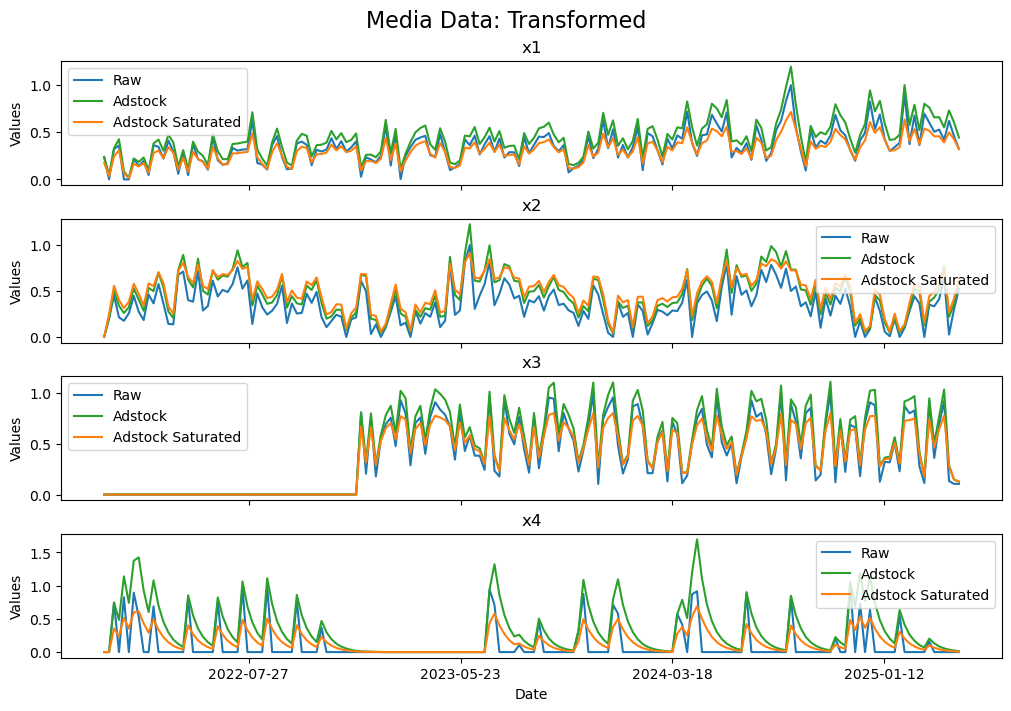

In [6]:
fig, ax = plt.subplots(
    nrows=4, ncols=1, figsize=(10, 7), sharex=True, layout="constrained"
)

sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0], label="Raw")
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C2", ax=ax[0], label="Adstock")
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C1", ax=ax[0], label="Adstock Saturated")
ax[0].set(title="x1")

sns.lineplot(x="date_week", y="x2", data=df, color="C0", ax=ax[1], label="Raw")
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C2", ax=ax[1], label="Adstock")
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[1], label="Adstock Saturated")
ax[1].set(title="x2")

sns.lineplot(x="date_week", y="x3", data=df, color="C0", ax=ax[2], label="Raw")
sns.lineplot(x="date_week", y="x3_adstock", data=df, color="C2", ax=ax[2], label="Adstock")
sns.lineplot(x="date_week", y="x3_adstock_saturated", data=df, color="C1", ax=ax[2], label="Adstock Saturated")
ax[2].set(title="x3")

sns.lineplot(x="date_week", y="x4", data=df, color="C0", ax=ax[3], label="Raw")
sns.lineplot(x="date_week", y="x4_adstock", data=df, color="C2", ax=ax[3], label="Adstock")
sns.lineplot(x="date_week", y="x4_adstock_saturated", data=df, color="C1", ax=ax[3], label="Adstock Saturated")
ax[3].set(title="x4")


for a in ax.flat:
    a.set(xlabel="Date", ylabel="Values")
    a.legend()
    a.xaxis.set_major_locator(plt.MaxNLocator(5))  # Spread out the dates more

fig.suptitle("Media Data: Transformed", fontsize=16)
plt.show()

## 2. Trend and Seasonality

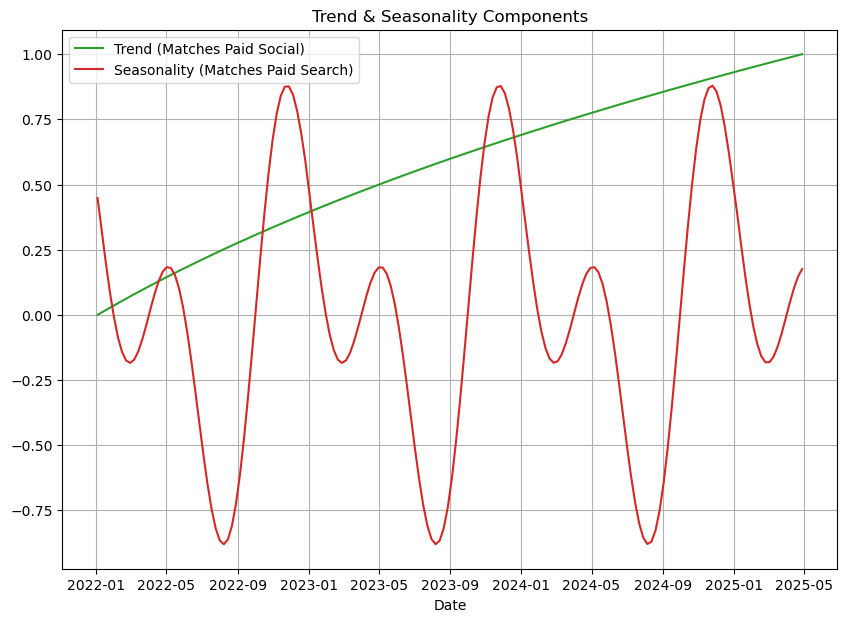

In [7]:
# Trend: Match x1
# Generate the original trend values
df["trend"] = (np.linspace(5000, 15000, n) + 10) ** (1 / 4) - 1
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Reshape the data before scaling (MinMaxScaler expects 2D input)
df["trend"] = scaler.fit_transform(df["trend"].values.reshape(-1, 1)).flatten()

# Seasonality: Match x2 Seasonality
df["dayofyear"] = df["date_week"].dt.dayofyear
df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(x="date_week", y="trend", color="C2", label="Trend (Matches Paid Social)", data=df, ax=ax)
sns.lineplot(x="date_week", y="seasonality", color="C3", label="Seasonality (Matches Paid Search)", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="Date", ylabel=None)
plt.grid(True)
plt.show()

## 3. Control Variables

In [8]:
# c1: Binary variable for occasional promotions
c1 = rng.choice([0, 1], size=n, p=[0.85, 0.15])  # Promotions occur 15% of the time
df["c1"] = c1

# Ensure date_week is in datetime format
# Function to check if a week contains December 25
def contains_christmas(date):
    year = date.year
    # Get December 25th of that year
    christmas_day = pd.Timestamp(year, 12, 25)
    # Check if the given date's week contains December 25th
    return 1 if date <= christmas_day < (date + pd.Timedelta(days=7)) else 0

# Apply function to identify Christmas week
df["c2"] = df["date_week"].apply(contains_christmas)

c3 = rng.uniform(low=0.0, high=1.0, size=n)
df["c3"] = np.where(c3 > 0.8, c3, c3 / 2)


scaler = MinMaxScaler(feature_range=(0, 1))
df[["c1", "c2", "c3"]] = scaler.fit_transform(df[["c1", "c2", "c3"]])

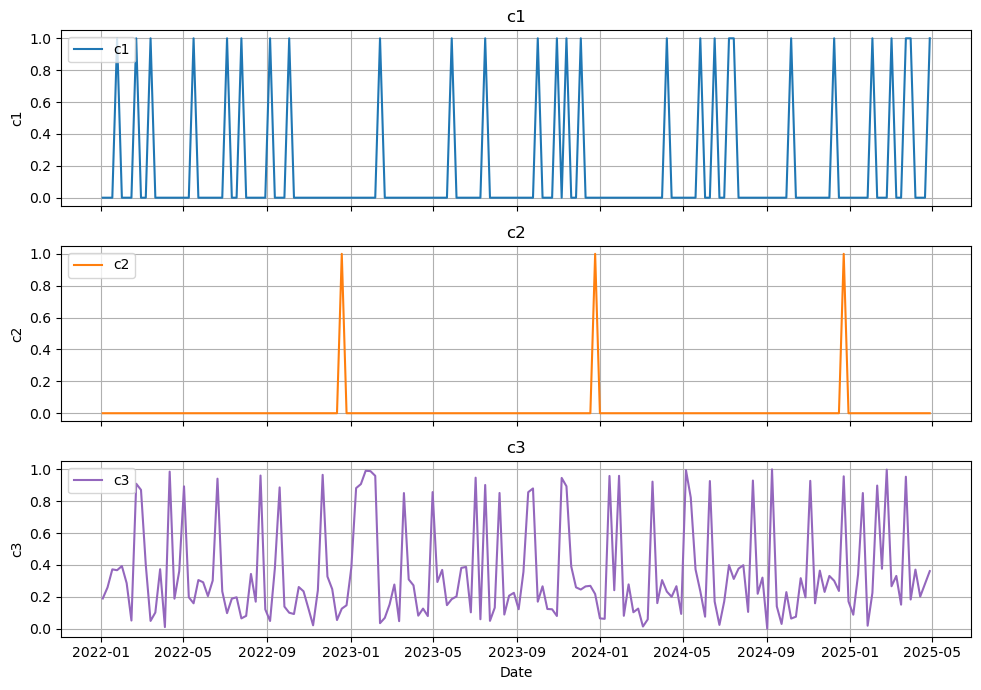

In [9]:
# Create subplots with 3 rows and 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 7), sharex=True)

# Plot CPI
sns.lineplot(x="date_week", y="c1", color="C0", label="c1", data=df, ax=axes[0])
axes[0].set(title="c1", ylabel="c1")
axes[0].legend(loc="upper left")
axes[0].grid(True)

# Plot Promotions
sns.lineplot(x="date_week", y="c2", color="C1", label="c2", data=df, ax=axes[1])
axes[1].set(title="c2", ylabel="c2")
axes[1].legend(loc="upper left")
axes[1].grid(True)

# Plot Christmas Indicator
sns.lineplot(x="date_week", y="c3", color="C4", label="c3", data=df, ax=axes[2])
axes[2].set(title="c3", xlabel="Date", ylabel="c3")
axes[2].legend(loc="upper left")
axes[2].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

## 4. Target Variable

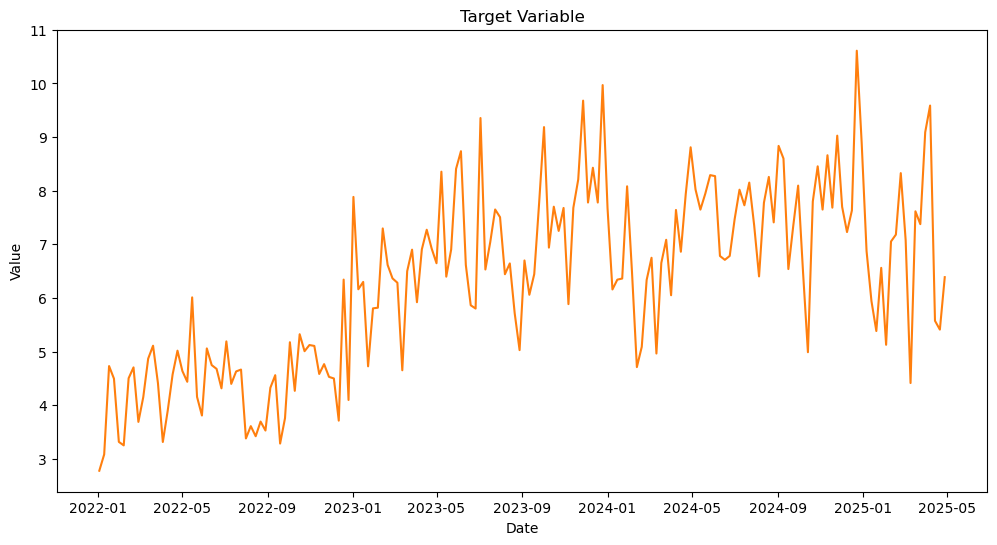

In [10]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1

beta_x1 = 1.5
beta_x2 = 3.0
beta_x3 = 4.0
beta_x4 = 1.0
channel_betas = [beta_x1, beta_x2, beta_x3, beta_x4]

beta_c1 = 0.6
beta_c2 = 2.0
beta_c3 = 0.2
control_betas = [beta_c1, beta_c2, beta_c3]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + beta_c1 * df["c1"]
    + beta_c2 * df["c2"]
    + beta_c3 * df["c3"]
    + beta_x1 * df["x1_adstock_saturated"]
    + beta_x2 * df["x2_adstock"]
    + beta_x3 * df["x3_adstock_saturated"]
    + beta_x4 * df["x4_adstock_saturated"]
    + df["epsilon"]
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="date_week", y="y", color="C1", data=df, ax=ax)
ax.set(title="Target Variable", xlabel="Date", ylabel="Value")
plt.show()

## Extracting only the cols needed for modelling

In [11]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "x3",
    "x4",
    "c1",
    "c2",
    "c3",
]

data = df[columns_to_keep].copy()

data.head()

,date_week,y,x1,x2,x3,x4,c1,c2,c3
0,2022-01-03,2.780730,0.237696,0.000000,0.0,0.000000,0.0,0.0,0.189850
1,2022-01-10,3.085093,0.000000,0.204626,0.0,0.000000,0.0,0.0,0.259375
2,2022-01-17,4.732001,0.322460,0.451825,0.0,0.743736,0.0,0.0,0.372605
3,2022-01-24,4.496932,0.358948,0.214416,0.0,0.000000,1.0,0.0,0.367273
4,2022-01-31,3.318373,0.000000,0.175842,0.0,0.824213,0.0,0.0,0.393389


In [12]:
data.to_csv("model_data.csv", index = False)

### True insights - used for recovery

- Sales attribution.
- ROAS.
- Contributions over time.

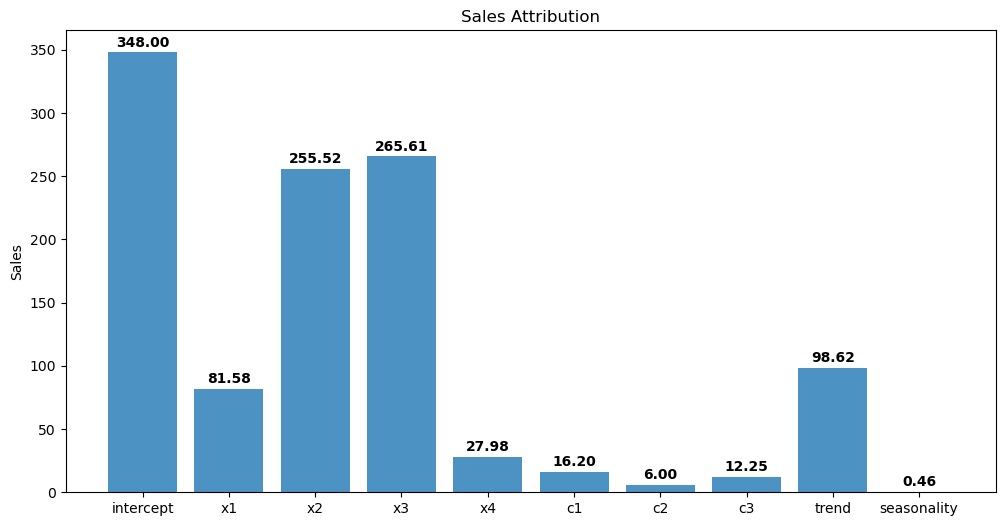

In [13]:
fig, ax = plt.subplots(figsize = (12,6))

contributions = [
    df["intercept"].sum(),
    (beta_x1 * df["x1_adstock_saturated"]).sum(),
    (beta_x2 * df["x2_adstock_saturated"]).sum(),
    (beta_x3 * df["x3_adstock_saturated"]).sum(),
    (beta_x4 * df["x4_adstock_saturated"]).sum(),
    (beta_c1 * df["c1"]).sum(),
    (beta_c2 * df["c2"]).sum(),
    (beta_c3 * df["c3"]).sum(),
    df["trend"].sum(),
    df["seasonality"].sum(),
]

ax.bar(
    ["intercept", "x1", "x2", "x3", "x4", "c1", "c2", "c3", "trend", "seasonality"],
    contributions,
    color=["C0" if x >= 0 else "C3" for x in contributions],
    alpha=0.8,
)
ax.bar_label(
    ax.containers[0],
    fmt="{:,.2f}",
    label_type="edge",
    padding=2,
    fontsize=10,
    fontweight="bold",
)
ax.set(title="Sales Attribution", ylabel="Sales");

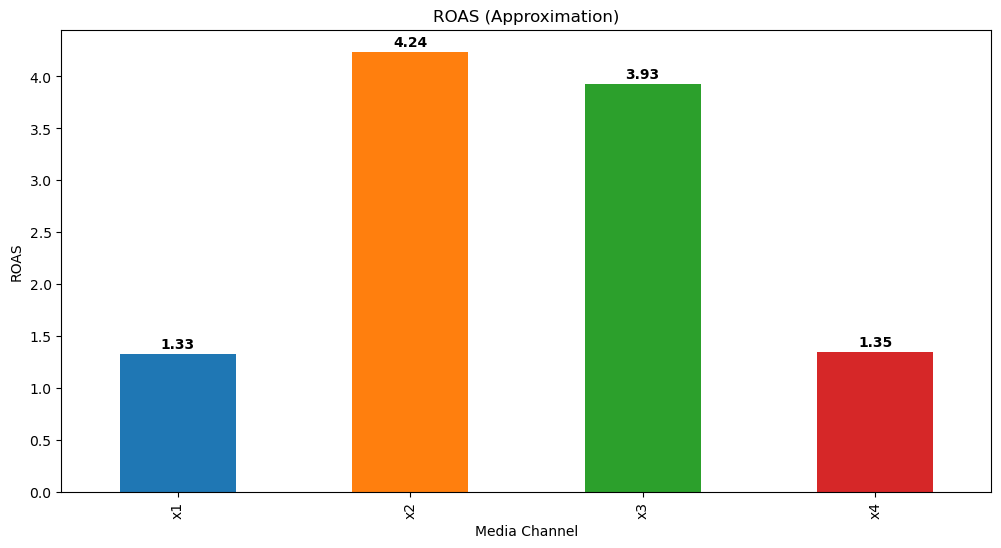

In [14]:
roas_1 = (amplitude * beta_x1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_x2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()
roas_3 = (amplitude * beta_x3 * df["x3_adstock_saturated"]).sum() / df["x3"].sum()
roas_4 = (amplitude * beta_x4 * df["x4_adstock_saturated"]).sum() / df["x4"].sum()
fig, ax = plt.subplots(figsize=(12, 6))
(
    pd.Series(data=[roas_1, roas_2, roas_3, roas_4], index=["x1", "x2", "x3", "x4"]).plot(
        kind="bar", color=["C0", "C1", "C2", "C3"]
    )
)

ax.bar_label(
    ax.containers[0],
    fmt="{:,.2f}",
    label_type="edge",
    padding=2,
    fontsize=10,
    fontweight="bold",
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

In [15]:
# Creating the DataFrame
contributions_over_time_df = pd.DataFrame({
    "date_week": df["date_week"],
    "intercept": df["intercept"],
    "x1_contribution": beta_x1 * df["x1_adstock_saturated"],
    "x2_contribution": beta_x2 * df["x2_adstock_saturated"],
    "x3_contribution": beta_x3 * df["x3_adstock_saturated"],
    "x4_contribution": beta_x4 * df["x4_adstock_saturated"],
    "c1_contribution": beta_c1 * df["c1"],
    "c2_contribution": beta_c2 * df["c2"],
    "c3_contribution": beta_c3 * df["c3"],
    "trend": df["trend"],
    "seasonality": df["seasonality"]
})

# Display the DataFrame
contributions_over_time_df.to_csv("true_contribution_data_over_time.csv", index = False)

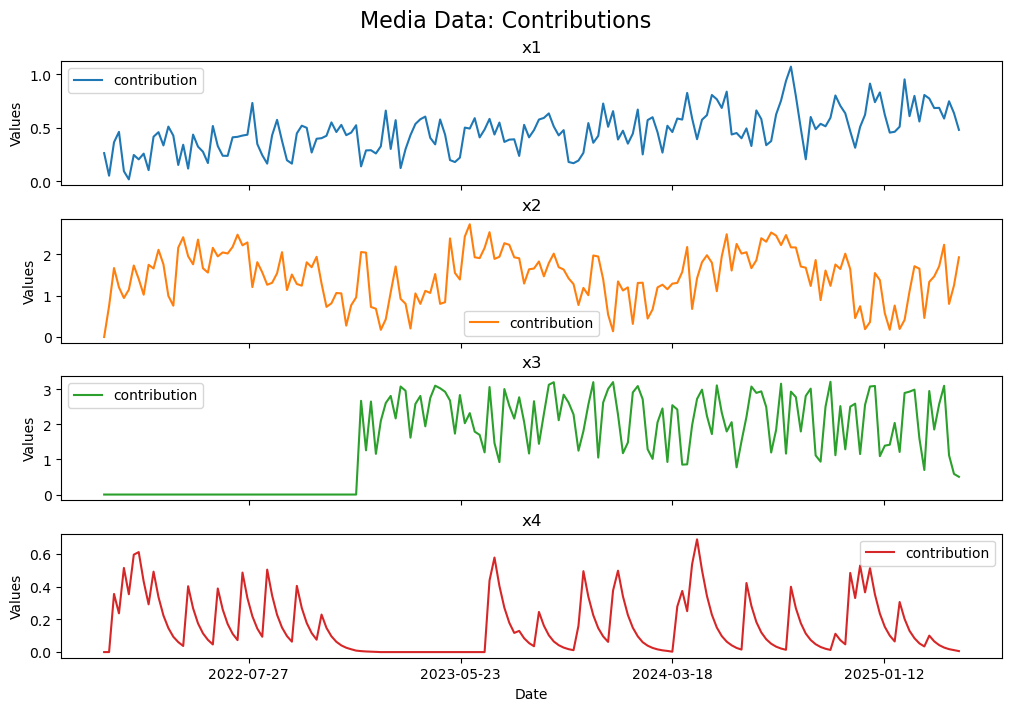

In [16]:
fig, ax = plt.subplots(
    nrows=4, ncols=1, figsize=(10, 7), sharex=True, layout="constrained"
)

sns.lineplot(x="date_week", y="x1_contribution", data=contributions_over_time_df, color="C0", ax=ax[0], label="contribution")
ax[0].set(title="x1")

sns.lineplot(x="date_week", y="x2_contribution", data=contributions_over_time_df, color="C1", ax=ax[1], label="contribution")
ax[1].set(title="x2")

sns.lineplot(x="date_week", y="x3_contribution", data=contributions_over_time_df, color="C2", ax=ax[2], label="contribution")
ax[2].set(title="x3")

sns.lineplot(x="date_week", y="x4_contribution", data=contributions_over_time_df, color="C3", ax=ax[3], label="contribution")
ax[3].set(title="x4")


for a in ax.flat:
    a.set(xlabel="Date", ylabel="Values")
    a.legend()
    a.xaxis.set_major_locator(plt.MaxNLocator(5))  # Spread out the dates more

fig.suptitle("Media Data: Contributions", fontsize=16)
plt.show()